In [1]:
## Indians_xgboost.py
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import pickle

In [2]:
# 准备测试集
test=pd.read_csv('test.csv')
X_test=test.drop('label',axis=1).values
y_test=test['label'].values

### 我们一共有50个RSP，12，34，56，这样两两合一，一共就25个RSP


In [18]:
# 在25个RSP上分别训练XGBOOST
for i in range(1,50,2):
    b=[i,i+1]
    # 准备训练集
    Block=np.vstack((
        pd.read_csv('Blocks/Block '+str(b[0])+'.csv').values,
        pd.read_csv('Blocks/Block '+str(b[1])+'.csv').values,
    ))
    
    print('------------------------------------------------------------------------------')
    path='Params/RSP25 XGBoost/xlf_'+str(b[0])+'+'+str(b[1])+'.json'
    print(path)
    X_train=Block[:,1:]
    y_train=Block[:,0]

    # 模型
    xlf = XGBClassifier(
                max_depth=10,
                learning_rate=0.05,
                n_estimators=6000,
                objective='binary:logistic',
                nthread=-1,
                gamma=0,
                min_child_weight=1,
                max_delta_step=0,
                colsample_bytree=0.8,
                colsample_bylevel=1,
                reg_alpha=0,
                reg_lambda=1,
                scale_pos_weight=1,
    )

    xlf.fit(X_train, y_train, eval_metric='error', verbose=100, eval_set=[(X_test, y_test)], early_stopping_rounds=30)
    # 这个verbose主要是调节系统输出的，如果设置成10,便是每迭代10次就有输出。
    # 注意我们这里eval_metric=‘error’便是准确率。这里面并没有accuracy命名的函数，网上大多例子为auc，我这里特意放了个error。
    xlf.save_model(path)

    y_pred = xlf.predict(X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    
    
    print('------------------------------------------------------------------------------')

------------------------------------------------------------------------------
Params/RSP25 XGBoost/xlf_1+2.json
[0]	validation_0-error:0.33802
[100]	validation_0-error:0.26336
[200]	validation_0-error:0.25977
[300]	validation_0-error:0.25866
[400]	validation_0-error:0.25836
[500]	validation_0-error:0.25794
[600]	validation_0-error:0.25758
[700]	validation_0-error:0.25730
[765]	validation_0-error:0.25728
Accuracy: 74.28%
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Params/RSP25 XGBoost/xlf_3+4.json
[0]	validation_0-error:0.33744
[100]	validation_0-error:0.26324
[200]	validation_0-error:0.25980
[300]	validation_0-error:0.25894
[400]	validation_0-error:0.25838
[500]	validation_0-error:0.25802
[600]	validation_0-error:0.25747
[636]	validation_0-error:0.25746
Accuracy: 74.26%
------------------------------------------------------------------------------
-------------------------

[300]	validation_0-error:0.25830
[400]	validation_0-error:0.25812
[500]	validation_0-error:0.25757
[600]	validation_0-error:0.25718
[673]	validation_0-error:0.25704
Accuracy: 74.30%
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Params/RSP25 XGBoost/xlf_39+40.json
[0]	validation_0-error:0.33811
[100]	validation_0-error:0.26328
[200]	validation_0-error:0.25960
[300]	validation_0-error:0.25855
[400]	validation_0-error:0.25817
[425]	validation_0-error:0.25815
Accuracy: 74.19%
------------------------------------------------------------------------------
------------------------------------------------------------------------------
Params/RSP25 XGBoost/xlf_41+42.json
[0]	validation_0-error:0.33562
[100]	validation_0-error:0.26293
[200]	validation_0-error:0.25898
[300]	validation_0-error:0.25801
[385]	validation_0-error:0.25774
Accuracy: 74.23%
-------------------------------------


KeyboardInterrupt



#### 这里训练到45+46就停止的原因是， 我在colab同时跑，两个相遇问题，得到了25个分类器的参数后就停止了

#### 看看单个块上的FEATURE IMPORTANCE   ,这个图片不清楚，会另外上传

The AUROC = 0.741232


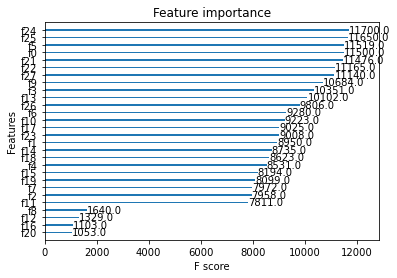

In [38]:
%matplotlib inline

from xgboost import plot_importance
from sklearn.metrics import roc_auc_score

# model.fit(X, Y)
plot_importance(xlf,max_num_features=28,grid=False)

roc=roc_auc_score(y_test,y_pred)

print("The AUROC = %f"%roc)
plt.show()


## 接下来是渐进学习

In [12]:
n_block=25
nets=[]
for i in range(1,49+1,2):
    b=[i,i+1]
    path='Params/RSP25 XGBoost/xlf_'+str(b[0])+'+'+str(b[1])+'.json'
    net=XGBClassifier()
    net.load_model(path)
    nets.append(net)
    print(i,' ok')

1  ok
3  ok
5  ok
7  ok
9  ok
11  ok
13  ok
15  ok
17  ok
19  ok
21  ok
23  ok
25  ok
27  ok
29  ok
31  ok
33  ok
35  ok
37  ok
39  ok
41  ok
43  ok
45  ok
47  ok
49  ok


In [25]:
y_preds=[]
y_preds.append(0)
for i,net in enumerate(nets):
    y_preds.append(y_preds[i]+net.predict_proba(X_test))


In [54]:
preds=[]
for i in range(1,26):
    p=(y_preds[i][:,0]<y_preds[i][:,1])+0
    preds.append(p)

In [56]:
from sklearn import metrics


In [72]:
ss_roc_auc_score=[]
ss_accuracy_score=[]
ss_recall_score=[]
ss_f1_score=[]
ss_precision_score=[]
ss_confusion_matrix=[]
print('           AUC                ACC                  Recall                F1-Score                Precesion')
for i in range(25):
    
    a=metrics.roc_auc_score(y_test,preds[i])
    b=metrics.accuracy_score(y_test,preds[i])
    c=metrics.recall_score(y_test,preds[i])
    d=metrics.f1_score(y_test,preds[i])
    e=metrics.precision_score(y_test,preds[i])
    m=metrics.confusion_matrix(y_test,preds[i])
    
    ss_roc_auc_score.append(a)
    ss_accuracy_score.append(b)
    ss_recall_score.append(c)
    ss_f1_score.append(d)
    ss_precision_score.append(e)
    ss_confusion_matrix.append(m)
    
    
    print(i+1,'    ',a,'    ',b,'    ',c,'    ',d,'    ',e)
    
    
#     print ('AUC: %.4f' % a)   
#     print ('ACC: %.4f' % b)
#     print ('Recall: %.4f' % c)
#     print ('F1-score: %.4f' %d)
#     print ('Precesion: %.4f' %e)
    
    



           AUC                ACC                  Recall                F1-Score                Precesion
1      0.7413141792289297      0.7427851515151516      0.7658837421409722      0.759376574219832      0.7529790482786847
2      0.7444808751386621      0.7458763636363637      0.7677896368049817      0.7620299170886768      0.7563559692004544
3      0.7456425721737024      0.7469975757575757      0.7682751167238969      0.7629451868879195      0.757688700606073
4      0.745849609128782      0.7471945454545454      0.7683140008634566      0.7630951671025616      0.7579467536899822
5      0.746160861804387      0.747520303030303      0.7688675280266013      0.7634582697749315      0.7581245919238415
6      0.7461364719816117      0.7474851515151515      0.7686633862939126      0.7633851664213817      0.7581789406238578
7      0.7462533857862336      0.7476145454545454      0.7689887550499347      0.7635541484597145      0.7581958178452809
8      0.7463438795682059      0.74768787878

            AUC                ACC               Recall            F1-Score            Precesion
1       0.7413141792289297      0.7427851515151516      0.7658837421409722      0.759376574219832       0.7529790482786847
2       0.7444808751386621      0.7458763636363637      0.7677896368049817      0.7620299170886768      0.7563559692004544
3       0.7456425721737024      0.7469975757575757      0.7682751167238969      0.7629451868879195      0.757688700606073
4       0.745849609128782       0.7471945454545454      0.7683140008634566      0.7630951671025616      0.7579467536899822
5       0.746160861804387       0.747520303030303       0.7688675280266013      0.7634582697749315      0.7581245919238415
6       0.7461364719816117      0.7474851515151515      0.7686633862939126      0.7633851664213817      0.7581789406238578
7       0.7462533857862336      0.7476145454545454      0.7689887550499347      0.7635541484597145      0.7581958178452809
8       0.7463438795682059      0.7476878787878788      0.7687926188753906      0.7635605599374817      0.7583992337333331
9       0.7464675572267885      0.7478157575757576      0.7689864677476076      0.7636975721450897      0.758480930983352
10      0.7466785392858913      0.74801             0.7689178486777963      0.7638204998649497      0.7587902891780832
11      0.7467076046582495      0.7480545454545454      0.7692054769454221      0.7639198471223276      0.7587063624339744
12      0.7469358618685562      0.7482887878787878      0.7695337048293529      0.7641644509240818      0.7588696034646095
13      0.7470099835949491      0.7483633333333334      0.769614904061963       0.7642368383471274      0.7589334148341207
14      0.7469869674277423      0.7483430303030303      0.7696372052596517      0.7642275222523285      0.7588933564057934
15      0.7470055052766524      0.7483469696969697      0.7694119059804378      0.7641775854622156      0.7590140020375216
16      0.7470472568447644      0.7483866666666666      0.7694193397130007      0.7642077547081833      0.7590662950169719
17      0.7470355358662925      0.7483721212121213      0.7693604416780794      0.764183543182221       0.759075848007226
18      0.7470709591167783      0.7484154545454546      0.7695279865735354      0.7642538121428045      0.7590514416313859
19      0.7471190923397028      0.7484648484848485      0.7695971774689284      0.7643053836888442      0.7590858662798272
20      0.7470869738207666      0.7484424242424242      0.7697269818759882      0.7643197057388977      0.7589878710751277
21      0.7470334525955679      0.7483909090909091      0.7697069679806265      0.7642781342567909      0.7589253445901031
22      0.746964441259302       0.7483136363636363      0.769499967120029       0.7641743411665997      0.7589219246994067
23      0.7470287366680134      0.748379696969697       0.7695937465154379      0.764243602101614       0.7589673315400361
24      0.7470019578478188      0.7483539393939393      0.7695840254805479      0.7642228825594687      0.7589359174114557
25      0.7470516864844461      0.7484057575757576      0.7696686556666485      0.7642797987979779      0.7589658777318283

In [73]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'The number of RSP')

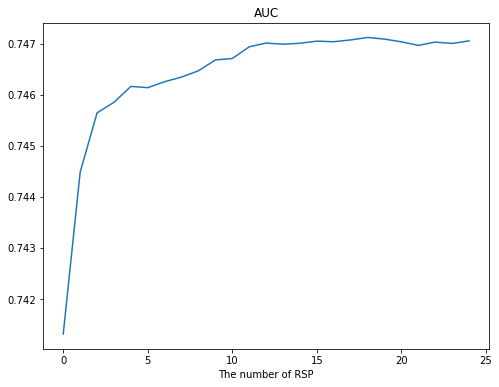

In [88]:
plt.figure(figsize=(8,6))
plt.plot(ss_roc_auc_score)
plt.title('AUC')
plt.xlabel('The number of RSP')

Text(0.5, 0, 'The number of RSP')

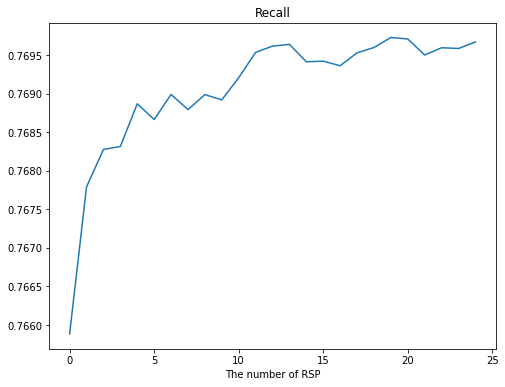

In [91]:
plt.figure(figsize=(8,6))
plt.plot(ss_recall_score)
plt.title('Recall')
plt.xlabel('The number of RSP')

Text(0.5, 0, 'The number of RSP')

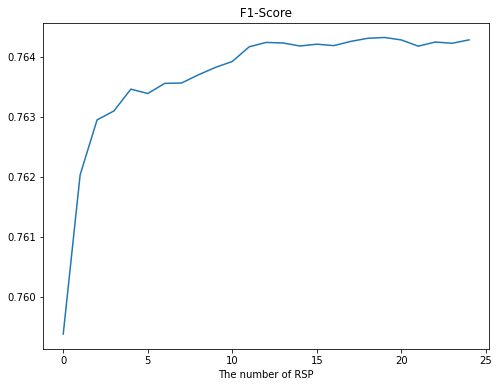

In [92]:
plt.figure(figsize=(8,6))
plt.plot(ss_f1_score)
plt.title(' F1-Score ')
plt.xlabel('The number of RSP')

Text(0.5, 0, 'The number of RSP')

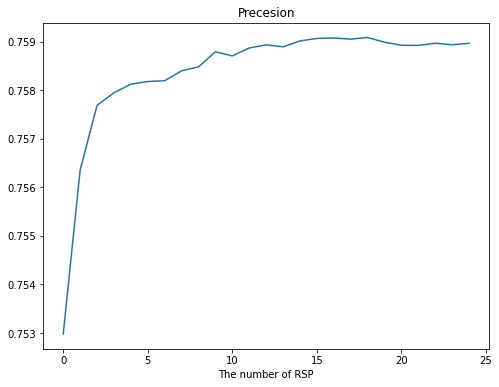

In [93]:
plt.figure(figsize=(8,6))
plt.plot(ss_precision_score)
plt.title('Precesion')
plt.xlabel('The number of RSP')

In [95]:
ss_confusion_matrix[-1]

array([[1123754,  427461],
       [ 402800, 1345985]], dtype=int64)

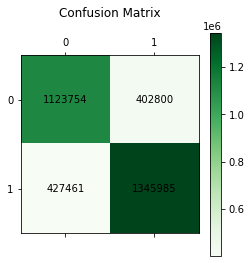

In [110]:
cm=ss_confusion_matrix[-1]
plt.matshow(cm,cmap=plt.cm.Greens)
plt.colorbar()
plt.title('Confusion Matrix\n')
for x in range(len(cm)):
    for y in range(len(cm)):    
        plt.annotate(cm[x,y],xy=(x,y),
        horizontalalignment='center',
        verticalalignment='center' 
                    )
plt.show()